In [4]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from bayesian_stats_course_tools.analyse import plot_data, analyse_data

In [2]:
title = "# Model checking"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Model checking

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## The Bayesian data analysis workflow

1. Model the data generating process probabilistically.
2. Condition the generative process on the observed data.
3. Check that the results fit the observed data and improve the model.

## Model checking

A first step to check your model is to plot it against the data.

If there are obvious issues, such as outliers, or misspecified errors, make some plots can already flag these problems.


### Chi-square goodness-of-fit

If the data $\vec y$ are Gaussian distributed
$$
    \vec y\sim \Norm\left(\vec \mu(\vec\theta), \Sigma(\vec\theta)\right)
$$
then a traditional test of how well our model fits the data is the chi-square test. 

Let us assume we have a set $\vec\theta^*$ of "best" model parameters. For example the MAP or mean of the posterior.

If these are the true parameters that generated the data and the data are Gaussian distributed, then the quantity
$$
    \chi^2(\vec y, \vec\theta^*) = \left(\vec y - \vec\mu(\vec\theta^*)\right)^T\Sigma(\vec\theta^*)^{-1}\left(\vec y - \vec\mu(\vec\theta^*)\right)
$$
is distributed as $\chi^2_\nu$. 



With this we can calculate the probability that the $\chi^2$ statistic would take a higher value than the one we have observed
$$
    \text{Probability to exceed (PTE) } \chi^2(\vec y, \vec\theta^*) = 1 - \mathrm{CDF}\left(\chi^2(\vec y, \vec\theta^*)\right)\ .
$$
If the PTE is small, this indicates that our model is a poor fit to the data.

The number of degrees of freedom is $\nu = n_\mathrm{data} - n_\mathrm{param}$, where $n_\mathrm{data}$ is the dimensionality of the data and $n_\mathrm{param}$ is the number of constrained parameters.


By fitting the model to the data, we reduce the scatter in the residuals $\vec y - \vec\mu(\theta)$, so the number of degrees of freedom is reduced from $n_\mathrm{data}$ by $n_\mathrm{param}$.

Finding $n_\mathrm{param}$ in a Bayesian context can be challenging because some parameters might be constrained by the prior, instead of by the likelihood. In this case, they do not reduce the degrees of freedom.

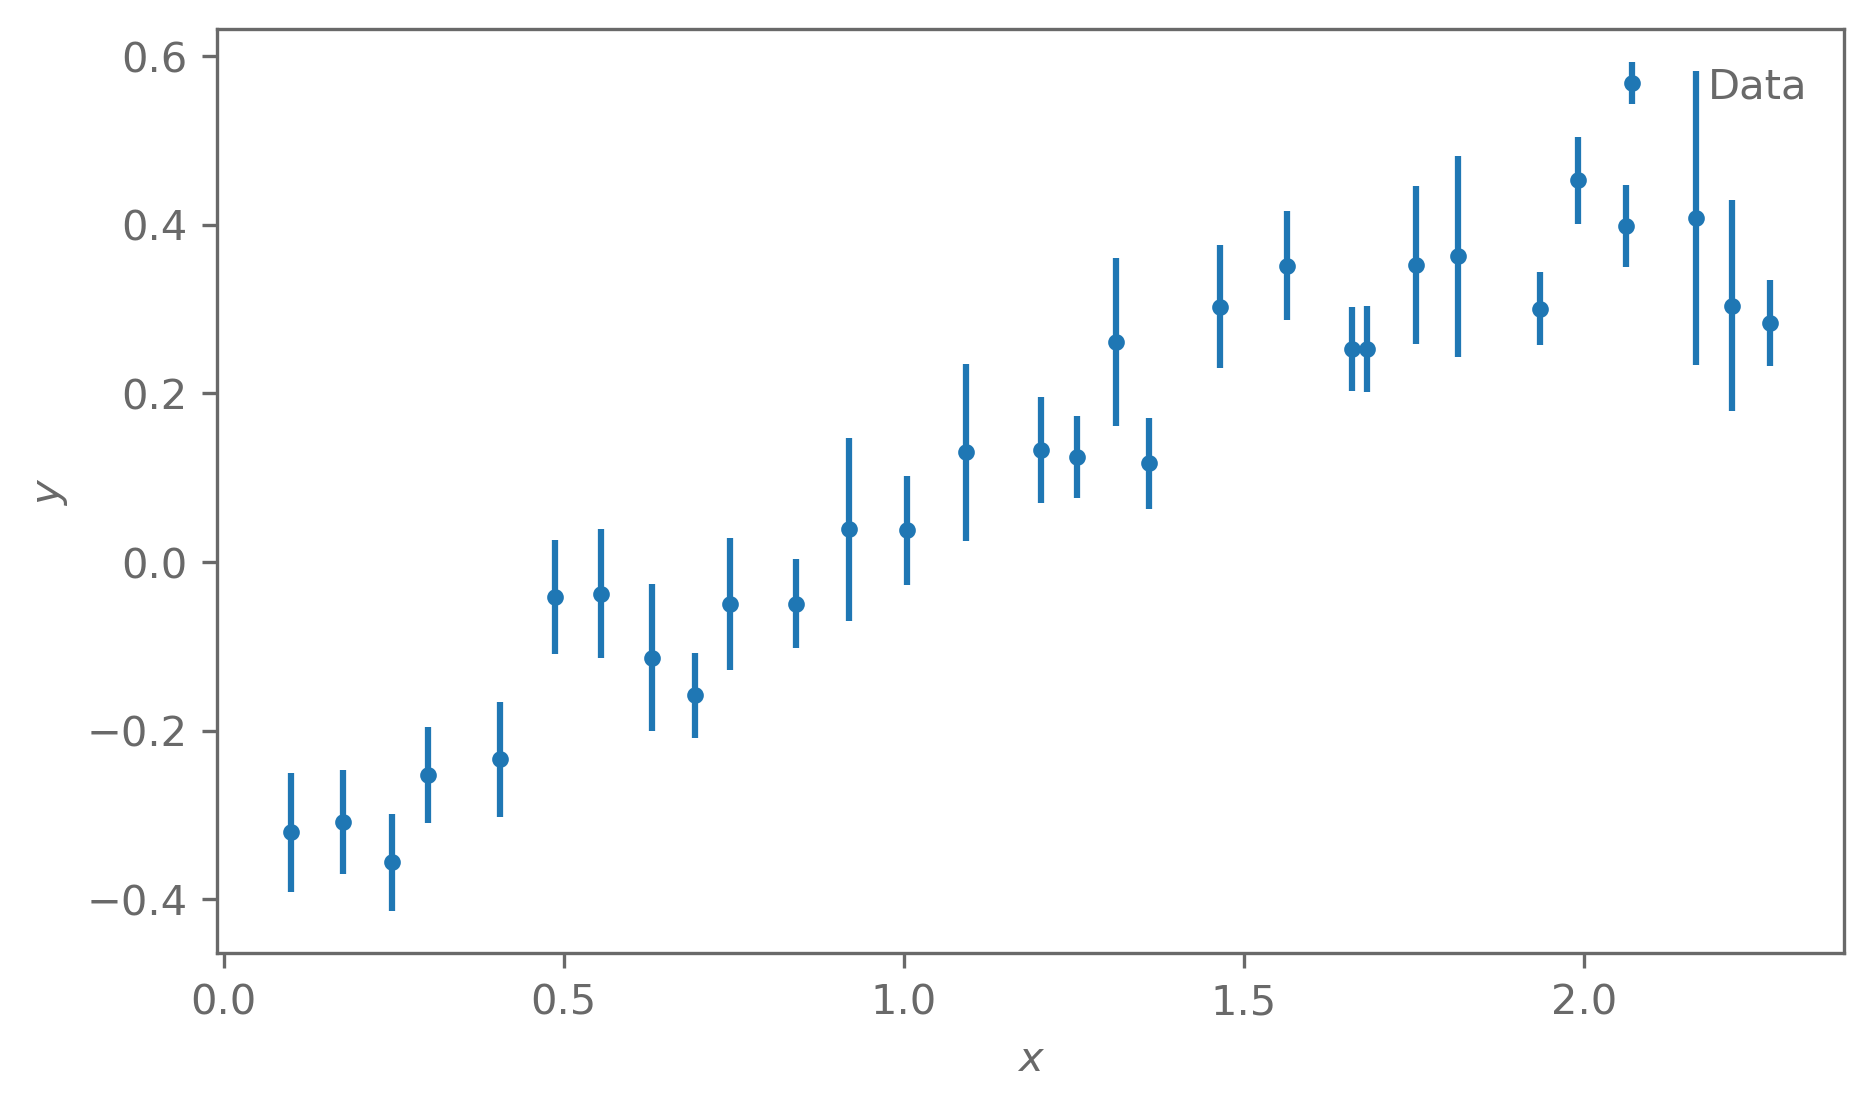

In [5]:
x, y, y_err = np.loadtxt("data/linear_fits/data_2.txt", unpack=True)
a_true, b_true, c_true,  = -0.15, 0.7, -0.45

plot_data(x, y, y_err);

In [190]:
def make_gaussian_likelihood_components(model, log_prior):
    """Create the log_likelihood, log_posterior, predict functions from a
    model and log_prior"""
    def log_likelihood(y, theta, x, sigma_y):
        prediction = model(theta, x)

        return (
            -0.5 * np.sum((y - prediction)**2/sigma_y**2)    # Exponent
            -0.5 * np.sum(np.log(2*np.pi*sigma_y**2))        # Normalisation
        )
    
    def log_posterior(theta, x, sigma_y, y):
        return log_likelihood(y, theta, x, sigma_y) + log_prior(theta)
    
    def predict(theta, x, sigma_y):
        mu = model(theta, x)
        return np.random.normal(loc=mu, scale=sigma_y)
    
    return log_likelihood, log_posterior, predict

In [191]:
def linear_model(theta, x):
    m, b = theta
    return m*x + b

def log_prior_linear_model(theta):
    m, b = theta
    # Unnormalised uniform prior m\simU(-2, 2), b \sim U(-3, 3)
    if -2 < m < 2 and -3 < b < 3:
        return 0
    else:
        return -np.inf

log_likelihood_lin, log_posterior_lin, predict_lin = \
    make_gaussian_likelihood_components(
        linear_model, log_prior_linear_model
    )

In [192]:
def quadratic_model(theta, x):
    a, b, c = theta
    return a*x**2 + b*x + c

def log_prior_quadratic_model(theta):
    a, b, c = theta
    # Unnormalised uniform prior m\simU(-2, 2), b \sim U(-3, 3)
    if -1 < a < 1 and -2 < b < 2 and -3 < c < 3:
        return 0
    else:
        return -np.inf

log_likelihood_quad, log_posterior_quad, predict_quad = \
    make_gaussian_likelihood_components(
        quadratic_model, log_prior_quadratic_model
    )

In [193]:
# From bayesian_stats_course_tools.analyse
# This function returns a dict with the following entries:
# - MAP: parameter values at the MAP
# - PPD: samples from the posterior predictive distribution
# - PPD_params: the parameter samples for the samples in of the PPD
# - TPD: samples from the TPD (samples of model predictions)
# - chain: MCMC chain of the parameters
results_linear = analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_lin,
    model_fn=linear_model,
    predict_fn=predict_lin,
    param_names=["m", "b"],
    theta_init=[1, 0],
    plot=False
)

results_quadratic = analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_quad,
    model_fn=quadratic_model,
    predict_fn=predict_quad,
    param_names=["a", "m", "b"],
    theta_init=[0.1, 1, 0],
    plot=False
)

/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP results
m_MAP = 0.34908377290541787
b_MAP = -0.33212704099855833


100%|██████████| 5000/5000 [00:01<00:00, 3838.56it/s]
/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Auto-correlation time of chain:
m = 25.3
b = 33.8
Posterior results (mean±std)
m = 0.35±0.02
b = -0.33±0.03
MAP results
a_MAP = -0.10547710642388063
m_MAP = 0.5990527808099008
b_MAP = -0.4340001193160153


100%|██████████| 5000/5000 [00:01<00:00, 4366.49it/s]

Auto-correlation time of chain:
a = 36.2
m = 39.1
b = 40.6
Posterior results (mean±std)
a = -0.11±0.03
m = 0.60±0.08
b = -0.44±0.04


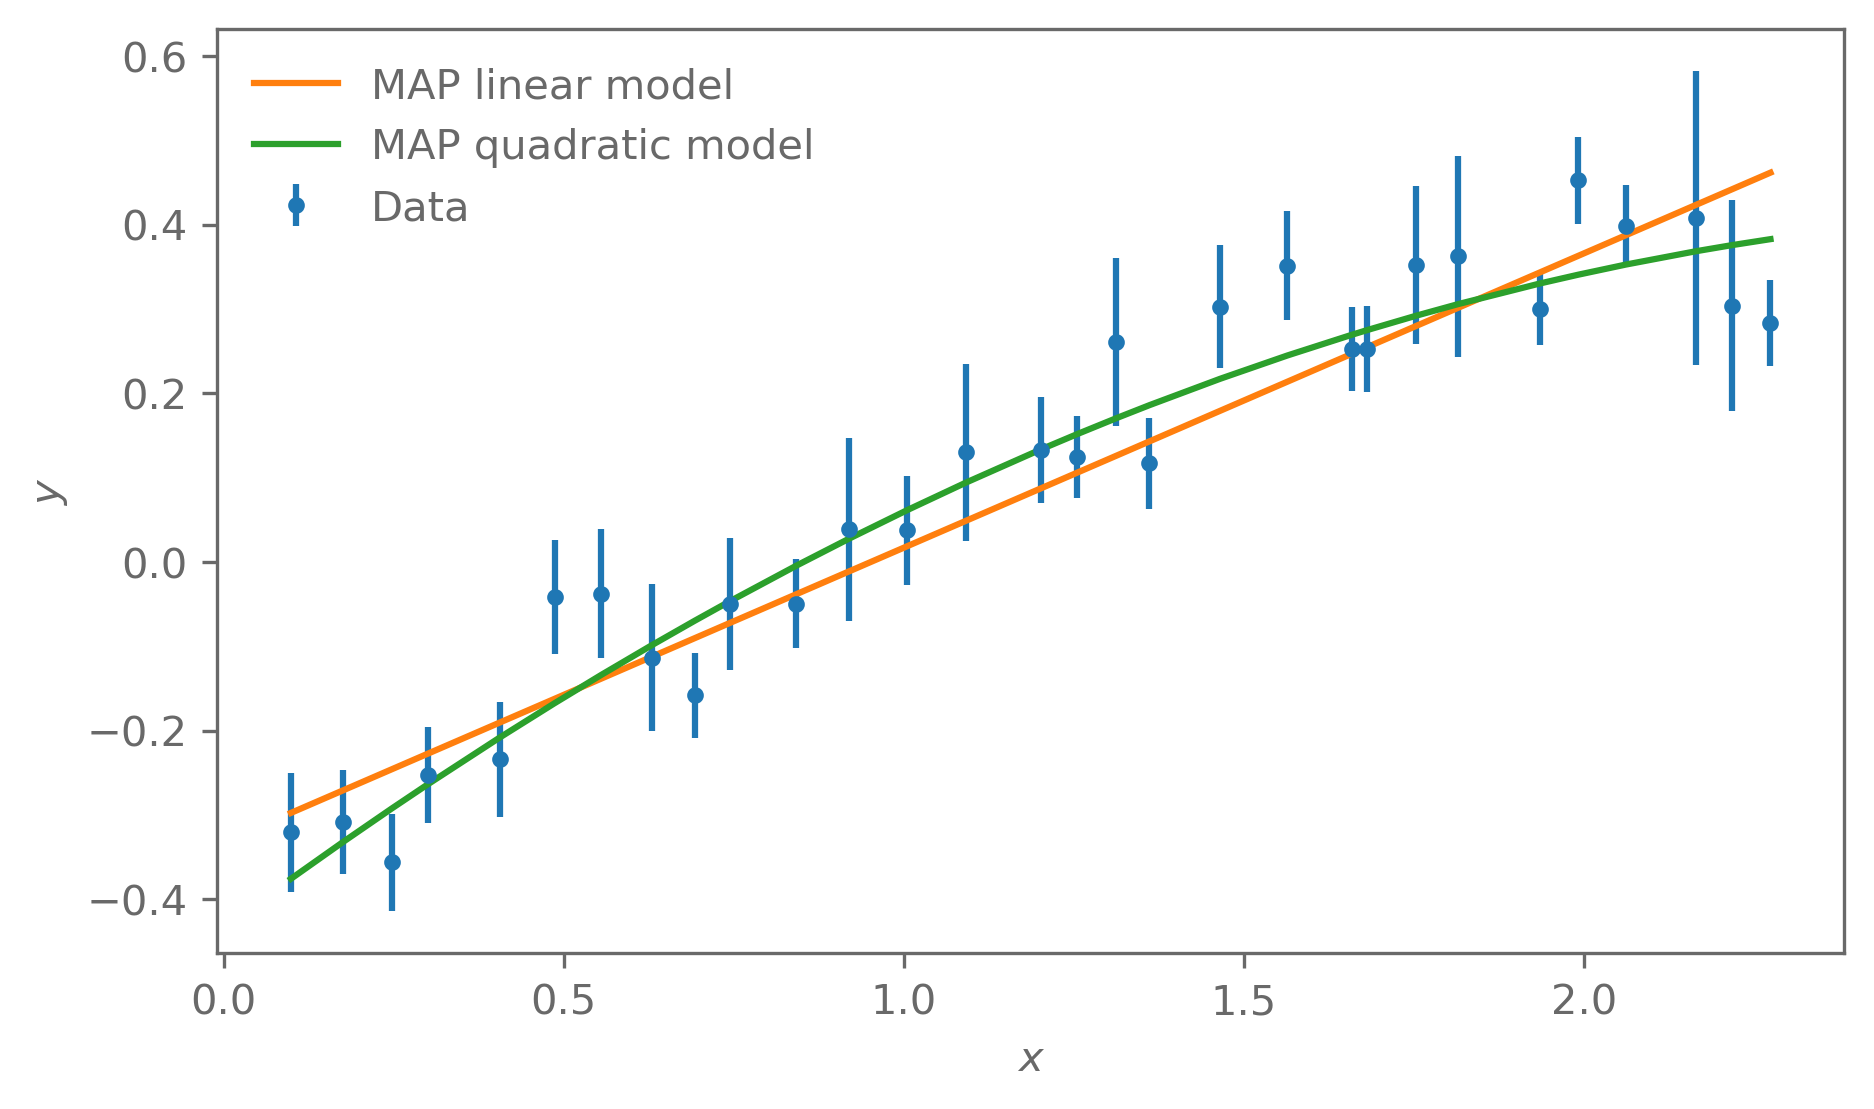

In [194]:
plot_data(
    x, y, y_err,
    models=[
        dict(x=x, y=linear_model(results_linear["MAP"], x), style=dict(label="MAP linear model")),
        dict(x=x, y=quadratic_model(results_quadratic["MAP"], x), style=dict(label="MAP quadratic model"))
    ]
);

In [195]:
def chi_squared(y, sigma_y, mu):
    return np.sum((y - mu)**2/sigma_y**2)

chi_squared_linear = chi_squared(
    y, y_err,
    mu=linear_model(results_linear["MAP"], x)
)
chi_squared_quadratic = chi_squared(
    y, y_err,
    mu=quadratic_model(results_quadratic["MAP"], x)
)

In [196]:
n_data = len(y)
n_param_lin = 2
n_param_quad = 3

PTE_lin = scipy.stats.chi2(df=n_data - n_param_lin).sf(chi_squared_linear)
PTE_quad = scipy.stats.chi2(df=n_data - n_param_quad).sf(chi_squared_quadratic)

print(f"Linear: χ²={chi_squared_linear:.1f}, "
      f"ndof={n_data}-{n_param_lin}, PTE={PTE_lin:.3f}")

print(f"Quadratic: χ²={chi_squared_quadratic:.1f}, "
      f"ndof={n_data}-{n_param_quad}, PTE={PTE_quad:.3f}")

Linear: χ²=40.8, ndof=30-2, PTE=0.056
Quadratic: χ²=29.3, ndof=30-3, PTE=0.347


### Posterior predictive checks

For more details, see chapter 6 in Bayesian Data Analysis

The chi-squared test has two downsides:
- It assumes the data is Gaussian distributed
- It uses a point estimate for the parameters $\vec\theta^*$ for which to calculate the goodness-of-fit. As Bayesians, we want to avoid point estimates and instead account for the full uncertainty in the posterior.


We use the posterior predictive distribution (PPD) to assess how well our model fits the data.

We define a test statistic $T(y, \theta)$ of the data and the parameters.
For example, we could choose the $\chi^2$ statistic
$$
    T(\vec y, \vec\theta) = \left(\vec y - \vec\mu(\vec\theta)\right)^T\Sigma(\vec\theta)^{-1}\left(\vec y - \vec\mu(\vec\theta)\right) \ .
$$

We then sample replicates $\vec y^\mathrm{rep}$ of the data from the PPD $p(\vec y^\mathrm{rep}|\vec y)$ and then compute the probability
$$
    \Pr\left(T(\vec y^\mathrm{rep}, \vec\theta) \geq T(\vec y, \vec\theta)|\vec y\right)\ .
$$

In practice:
1. Sample $S$ samples $\vec\theta_i$ from the posterior $p(\vec\theta|\vec y)$
2. Sample one $\vec y^\mathrm{rep}_i$ from the likelihood $p(\vec y^\mathrm{rep}|\vec\theta_i)$ for each $\theta_i$
3. Count the fraction of samples where $T(\vec y^\mathrm{rep}_i, \vec\theta_i) \geq T(\vec y, \vec\theta_i)$

In [197]:
def test_statistic(y, theta, x, sigma_y, model):
    mu = model(theta, x)
    t = chi_squared(y, sigma_y, mu)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))

    t_data = np.array(t_data)
    t_rep = np.array(t_rep)

    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data


In [205]:
PPD_PTE_lin, t_rep_lin, t_data_lin = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, x, y_err, linear_model),
    y=y,
    ppd=results_linear["PPD"],
    ppd_params=results_linear["PPD_params"]
)

PPD_PTE_quad, t_rep_quad, t_data_quad = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, x, y_err, quadratic_model),
    y=y,
    ppd=results_quadratic["PPD"],
    ppd_params=results_quadratic["PPD_params"]
)

print(f"Linear: PPD PTE={PPD_PTE_lin:.3f}")
print(f"Quadratic: PPD PTE={PPD_PTE_quad:.3f}")

Linear: PPD PTE=0.052
Quadratic: PPD PTE=0.336


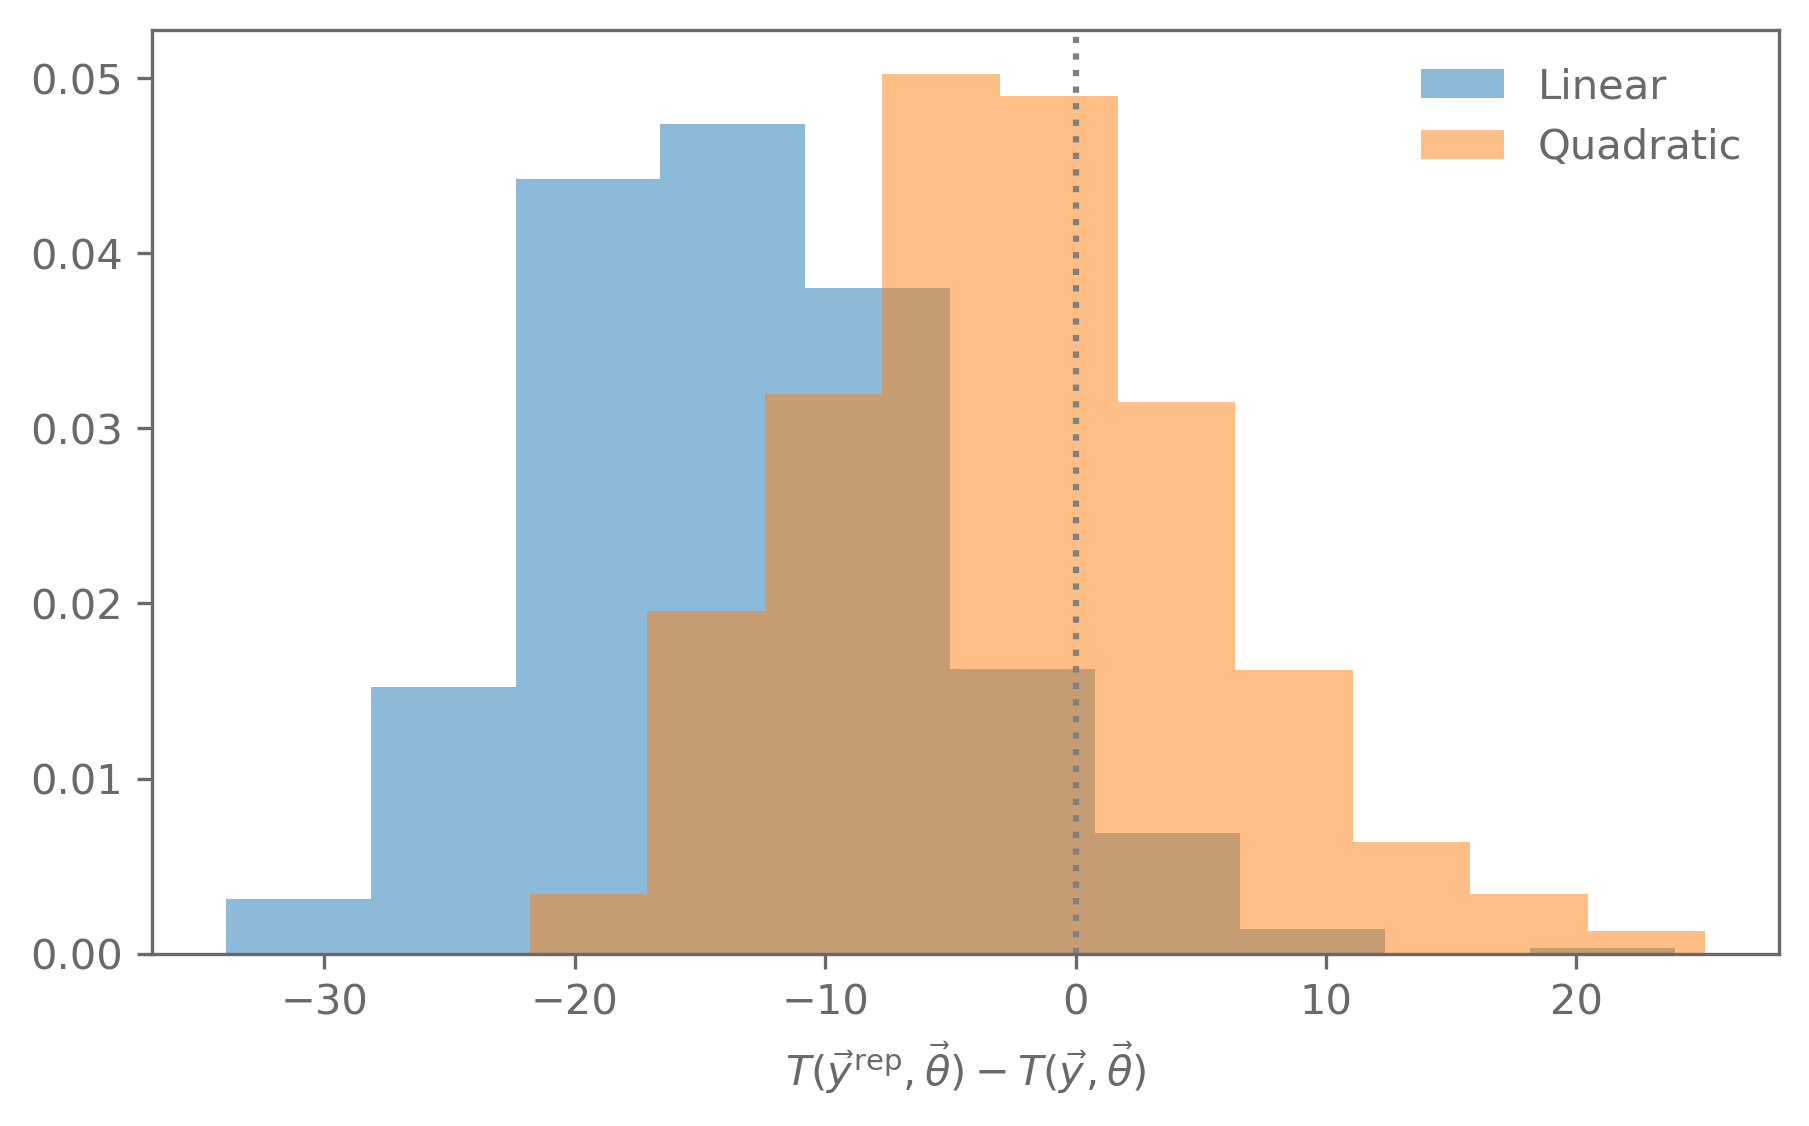

In [199]:
plt.hist(t_rep_lin - t_data_lin, density=True, alpha=0.5, label="Linear")
plt.hist(t_rep_quad - t_data_quad, density=True, alpha=0.5, label="Quadratic")
plt.axvline(0, ls=":", color="grey")
plt.legend(frameon=False)
plt.xlabel(r"$T(\vec y^\mathrm{rep}, \vec\theta) - T(\vec y, \vec\theta)$");

## Exercise

Reproduce the chi-squared test and PPD-based test with your own analysis code.


# Model comparison

After we have checked that the model is describing the data well, we might want to compare different models.

We have already discussed the Bayes ratio $\frac{p(y| M_1)}{p(y| M_2)}$ as a tool to decide between models.

Here we look at two other approaches to compare models that do not need computing the evidence.

## Deviance information criterion (DIC)

The deviance information criterion (DIC) is defined as
$$
    \text{DIC} = -2\left(\log p(\vec y |\vec\theta^*) - p_\mathrm{DIC}\right) \ ,
$$
with number of parameters
$$
    p_\mathrm{DIC} = 2\left(\log p(\vec y |\vec\theta^*) - \E[\log p(\vec y |\vec\theta)]\right)\ ,
$$
where the last term is the mean of the log likelihood over the posterior.

Interpretation: log-likelihood at the point best-fit parameter $\vec\theta^*$ minus the number of parameters in the model.

Adding more parameters that do not significantly improve the likelihood are penalised. 



In [200]:
def DIC(theta_star, theta_samples, log_likelihood):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star)
    log_likelihood_samples = np.array(
        [log_likelihood(theta) for theta in theta_samples]
    )
    p_DIC = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    return -2*(log_likelihood_star - p_DIC), p_DIC

In [201]:
DIC_lin, p_DIC_lin = DIC(
    theta_star=results_linear["MAP"],
    theta_samples=results_linear["PPD_params"],
    log_likelihood=lambda theta: log_likelihood_lin(y, theta, x, y_err)
)

DIC_quad, p_DIC_quad = DIC(
    theta_star=results_quadratic["MAP"],
    theta_samples=results_quadratic["PPD_params"],
    log_likelihood=lambda theta: log_likelihood_quad(y, theta, x, y_err)
)
print(f"Linear: DIC = {DIC_lin:.1f}, p_DIC = {p_DIC_lin:.1f}")
print(f"Quadratic: DIC = {DIC_quad:.1f}, p_DIC = {p_DIC_quad:.1f}")

Linear: DIC = -60.2, p_DIC = 2.0
Quadratic: DIC = -69.6, p_DIC = 3.0


## WAIC

The DIC is easy to calculate but has the downside that it relies on a point estimate for $\vec\theta^*$. A more Bayesian information criterion is the Watanabe-Akaike or widely applicable information criterion (WAIC).

It assumes we can partion the data into $M$ partions, for example the $n$ entries $y_i$ in the data vector $\vec y$. Then the log pointwise predictive density (lppd) is
$$
    \text{lppd} = \sum_{i=1}^n\log\E[p(y_i |\vec\theta)] = \sum_{i=1}^n\log\int p(y_i |\vec\theta)p(\vec\theta|\vec y)\dd \theta^n
$$

The number of parameters are estimated as
$$
    p_\mathrm{WAIC} = \sum_{i=1}^n \Var[\log p(\vec y_i |\vec\theta)]
$$

Finally, the WAIC is calculated as
$$
    \text{WAIC} = -2\left(\text{lppd} - p_\mathrm{WAIC}\right)
$$

In [206]:
def WAIC(theta_samples, log_likelihood, y_partitions, x_partitions, y_err_partitons):
    # Compute the log likelihood for each partition separately
    pointwise_log_likelihood_samples = np.array(
        [[log_likelihood(y_partitions[i], theta, x_partitions[i], y_err_partitons[i])
            for i in range(len(y_partitions))] 
         for theta in theta_samples]
    )

    # Compute the lppd and p_waic for each partition
    lppd = np.log(np.mean(np.exp(pointwise_log_likelihood_samples), axis=0))
    p_waic = np.var(pointwise_log_likelihood_samples, axis=0)
    # Check if the any of the terms in p_waic are too large, which indicates
    # a problem
    if np.any(p_waic > 0.4):
        print(f"Warning: Var[log p(y_i|theta)] > 0.4 for data points "
              f"{np.argwhere(p_waic > 0.4)}. p_WAIC unreliable!")
    # Sum up the partitions
    lppd = np.sum(lppd)
    p_waic = np.sum(p_waic)

    return -2*(lppd - p_waic), p_waic, pointwise_log_likelihood_samples

In [207]:
WAIC_lin, p_WAIC_lin, pointwise_log_likelihood_samples_lin = WAIC(
    theta_samples=results_linear["PPD_params"],
    log_likelihood=log_likelihood_lin,
    y_partitions=y,
    x_partitions=x,
    y_err_partitons=y_err
)

WAIC_quad, p_WAIC_quad, pointwise_log_likelihood_samples_quad = WAIC(
    theta_samples=results_quadratic["PPD_params"],
    log_likelihood=log_likelihood_quad,
    y_partitions=y,
    x_partitions=x,
    y_err_partitons=y_err
)
print()
print(f"Linear: WAIC = {WAIC_lin:.1f}, p_WAIC = {p_WAIC_lin:.1f}")
print(f"Quadratic: WAIC = {WAIC_quad:.1f}, p_WAIC = {p_WAIC_quad:.1f}")

 [29]]. p_WAIC unreliable!
 [29]]. p_WAIC unreliable!

Linear: WAIC = -57.7, p_WAIC = 3.9
Quadratic: WAIC = -67.6, p_WAIC = 4.3


## Cross-validation

Both the DIC and WAIC are approximations to leave-one-out cross-validation (LOO-CV). 

The idea behind cross-validation is to split the data into a training set $y_\mathrm{train}$ and a holdout set $y_\mathrm{holdout}$.

We then evaluate the PPD (using the posterior $p(\theta | y_\mathrm{train})$) at $y_\mathrm{holdout}$.

This checks if the model can predict each data point given all the other data points.



More specifically, we split the data into $n$ partions and for each compute
$$
    \log \int p(y_{i} | \theta)p(\theta | y_{(-i)}) \dd \theta\ ,
$$
where $y_i$ is the partion $i$ of the data and $y_{(-i)}$ is the data without the partion $i$.

This becomes computationally expensive quickly, since for each partion we need to create samples from the posterior $p(\theta | y_{(-i)})$. It also explicitly requires the data to be able to be split into partitions, which might be difficult for structured or dependent data.

A sophisticated approximation to LOO-CV that avoids recalculating the posterior for the partions is implemented in the package `arviz`. It also implements WAIC and other statistical diagnostics, for example for MCMC.

In [204]:
import arviz

inference_data_lin = arviz.from_dict(
    posterior={"lin": results_linear["PPD_params"][None, ...]},
    log_likelihood={"lin": pointwise_log_likelihood_samples_lin[None, ...]},
)

inference_data_quad = arviz.from_dict(
    posterior={"quad": results_quadratic["PPD_params"][None, ...]},
    log_likelihood={"quad": pointwise_log_likelihood_samples_quad[None, ...]},
)
arviz.compare({"lin": inference_data_lin, "quad": inference_data_quad}, ic="loo", scale="deviance")

/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
quad,0,-67.316012,4.412212,0.000000,0.818601,8.206187,0.000000,False,deviance
lin,1,-57.540861,4.032472,9.775151,0.181399,14.793016,9.490182,True,deviance


## Exercise

Do the model comparison using the Bayes factor, using nested sampling to get the evidences.

Try a cubic model. What are the DIC, WAIC, and Bayes factor?
